# Exercises: Linear Regression - Answer Key
By Christopher van Hoecke, Max Margenot, and Delaney Mackenzie

## Lecture Link : 
https://www.quantopian.com/lectures/linear-regression

### IMPORTANT NOTE: 
This lecture corresponds to the Linear Regression lecture, which is part of the Quantopian lecture series. This homework expects you to rely heavily on the code presented in the corresponding lecture. Please copy and paste regularly from that lecture when starting to work on the problems, as trying to do them from scratch will likely be too difficult.

Part of the Quantopian Lecture Series:

* [www.quantopian.com/lectures](https://www.quantopian.com/lectures)
* [github.com/quantopian/research_public](https://github.com/quantopian/research_public)

Notebook released under the Creative Commons Attribution 4.0 License.

----

## Key Concepts

In [1]:
# Useful Functions
def linreg(X,Y):
    # Running the linear regression
    X = sm.add_constant(X)
    model = regression.linear_model.OLS(Y, X).fit()
    a = model.params[0]
    b = model.params[1]
    X = X[:, 1]

    # Return summary of the regression and plot results
    X2 = np.linspace(X.min(), X.max(), 100)
    Y_hat = X2 * b + a
    plt.scatter(X, Y, alpha=0.3) # Plot the raw data
    plt.plot(X2, Y_hat, 'r', alpha=0.9);  # Add the regression line, colored in red
    plt.xlabel('X Value')
    plt.ylabel('Y Value')
    return model.summary()

In [2]:
# Useful Libraries
import math
import numpy as np
import matplotlib.pyplot as plt

from statsmodels import regression
from statsmodels.stats import diagnostic
import statsmodels.regression as smr
import statsmodels.api as sm
from statsmodels.stats.diagnostic import het_breushpagan

import scipy as sp
import scipy.stats
import seaborn


---

# Exercise 1: Temperatures
Given this set of Fahrenheit and Celsius values, find a model that expresses the relationship between the two temperature scales.

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       1.000
Model:                            OLS   Adj. R-squared:                  1.000
Method:                 Least Squares   F-statistic:                 7.818e+06
Date:                Tue, 19 Jun 2018   Prob (F-statistic):           8.33e-55
Time:                        18:08:12   Log-Likelihood:                -26.373
No. Observations:                  21   AIC:                             56.75
Df Residuals:                      19   BIC:                             58.83
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
const         32.1905      0.195    165.172      0.000        31.783    32.598
x1             1.7998      0.001   2795.998      0.000         1.798     1.801
==============================================================================
Omnibus:                       53.344   Durbin-Watson:                   2.112
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              281.704
Skew:                           4.210   Prob(JB):                     6.74e-62
Kurtosis:                      18.844   Cond. No.                         303.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

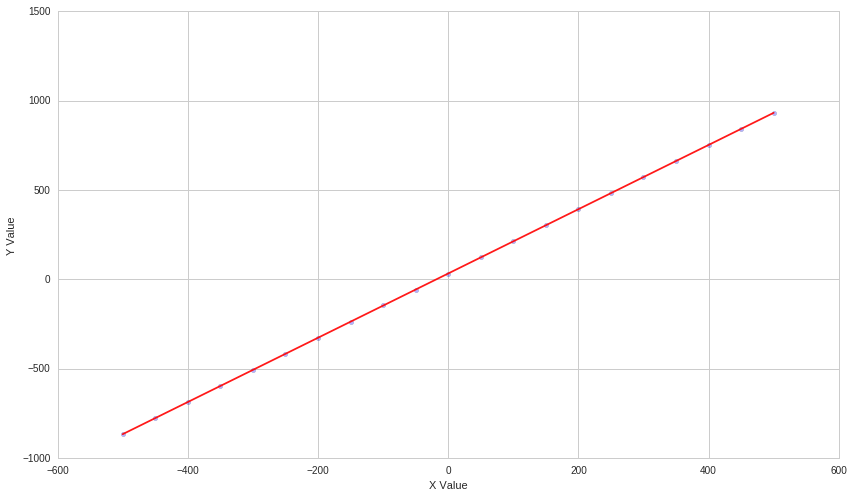

In [3]:
fahrenheit = [-868, -778, -688, -598, -508, -418, -328, -238, -144, -58, 32, 122, 212, 302, 392, 482, 
              572, 662, 752, 842, 932]
celsius    = [-500, -450, -400, -350, -300, -250, -200, -150, -100, -50, 0, 50, 100, 150, 200, 250, 
              300, 350, 400, 450, 500]

## Your code goes here
linreg(celsius, fahrenheit)

<center>*We can clearly see from the table (and the graph) that    $f = 1.8c + 32$ *</center>

----

# Exercise 2 : Confidence Intervals
## a. Visualizing Confidence Intervals 
Using the lecture series and the seaborn library, plot the regression line between the parameters and the $95\%$ confidence interval.

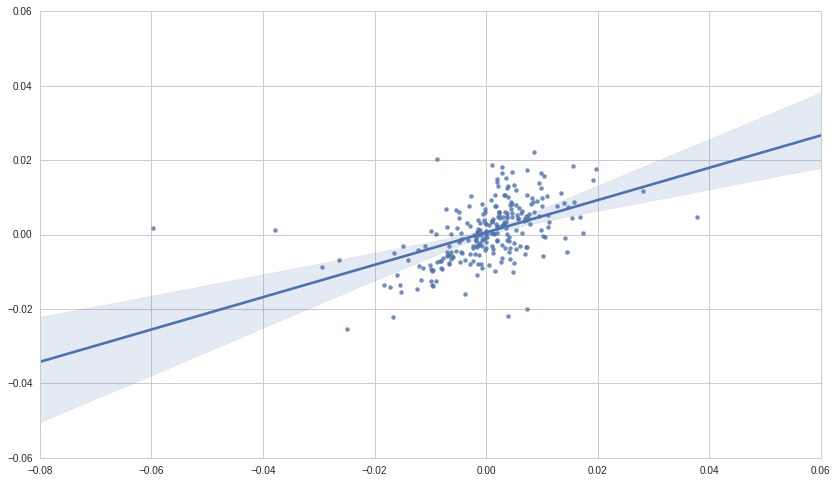

In [4]:
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('KO', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('PEP', fields='price', start_date=start, end_date=end)

returns1 = asset.pct_change()[1:]
returns2 = benchmark.pct_change()[1:]

## Your code goes here
seaborn.regplot(returns1.values, returns2.values, ci=95);

## b. Calculating Confidence Levels of Parameters. 
Let's directly calculate the $95\%$ confidence intervals of our parameters. The formula for a given parameter is:

$$ CI = \left(\beta - z \cdot \frac{s}{\sqrt{n}}, \beta + z \cdot \frac{s}{\sqrt{n}}\right) $$

Where,  $\beta$ is the coefficient, $z$ is the critical value*(t-statistic required to obtain a probability less than the alpha significance level)*, and $SE_{i,i}$ is the Standard Error Matrix. 

In [5]:
start = '2014-01-01'
end = '2015-01-01'
asset = get_pricing('KO', fields='price', start_date=start, end_date=end)
benchmark = get_pricing('PEP', fields='price', start_date=start, end_date=end)

X = asset.pct_change()[1:]
Y = benchmark.pct_change()[1:]

result = sm.OLS(Y,X).fit()

# Convert X to Matrix (adding columns of one)
X = np.vstack((X, np.ones( X.size ) ))
X = np.matrix( X )

# Matrix Multiplication and inverse calculation
C = np.linalg.inv( X * X.T )
C *= result.mse_resid
SE = np.sqrt(C) # Calucaltion of Standard Error. 

# Critical Values of the t-statistic
N = result.nobs
P = result.df_model
dof = N - P - 1
z = scipy.stats.t(dof).ppf(0.975)

i = 0
## Your code goes here

# Fetch values of Beta and parameters of SE from the matrix
beta = result.params[i]
c = SE[i,i]

print beta - z * c, beta + z * c

0.343562222943 0.530358115519


----

# Exercise 3 : $R^2$ Value

$R^2$ is the measure of how closely your data points are to the regression line, and is defined as $$ R^2 = 1 - \frac{\Sigma((y_{predicted} - (y_{actual}))^2)}{\Sigma( y_{predicited} - \frac{\Sigma y_{actual}}{len(y_{actual}})^2} $$ 
Given the information from exercise 1, calculate the value of $R^2$ manually.
You can start by expressing f as a function of c from the data obtained from Exercise 1 (these are the predicted values of y). 

In [6]:
# Creat an empty numpy array (float values). 
# Find the predicted value of f for every c in celsius (given by f = 32 + 1.8c)
fpred = np.array([])
f = [32 + 1.8*a for a in celsius] ## Your code goes here (fill in the values of Beta, and X1)
ypredicted = np.append(f, fpred)

Using the values of $y_{predicted}$  and  $y_{actual}$, calculate the squared element by element difference of the two lists, and sum them.

In [7]:
# Calucate the difference between the predicted values of y and the actual values of y, 
# Find the square of the difference
# Sum the Squares

ypred_yact = [a - b for a, b in zip(ypredicted, fahrenheit)] ## your code goes here (a - b)
diff1squared = [a**2 for a in ypred_yact] ## Your code goes here (a**2)
sumsquares1 = sum(diff1squared) ## Your code goes here 

Using the values of $y_{predicted}$ and mean, calculate the mean of the predicted values, along with the difference between $y_{predicted} - mean$. Square the values in the list obtained from the difference and sum them. 

In [8]:
# Calucate the difference between the predicted values of y and mean of y. 
# Find the square of the difference
# Sum the Squares

mean = sum(fahrenheit)/len(fahrenheit) ## Your code goes here
ypred_mean = [x - mean for x in ypredicted] ## Your code goes here (x-mean)
ypred_meansquared = [a**2 for a in ypred_mean] ## Your code goes here (a**2)
sumsquares2 = sum(ypred_meansquared) ## Your code goes here


We can now calculate the R-Squared by subtracting one to the ratio of the two sums. 

In [9]:
## Your code goes here
r = 1 - sumsquares1/sumsquares2

print 'R-squared = ', r

R-squared =  0.999997434664


----

# Exercise 4 : Residuals
**Defintion : In statistics, the residuals are differences between the predicted values and the actual values**: 

$$e = y - ŷ$$

## a. Residual Analysis I
- Model the data given bellow as a linear regression. 
- Calculate and plot the residual of the data sets *(remember to use the coefficient and the value of x1 to find the predicted values of y)*
- Print the sum of the residuals. 
- Discuss the choice of regression model. 

In [10]:
asset1 = get_pricing('SPY', fields='price', start_date='2005-01-01', end_date='2010-01-01')
asset2 = get_pricing('GS', fields='price', start_date='2005-01-01', end_date='2010-01-01')

returns1 = asset1.pct_change()[1:]
returns2 = asset2.pct_change()[1:]

## Your code goes here
results = smr.linear_model.OLS(returns2.values, sm.add_constant(returns1.values)).fit()

Run the Breush-Pagan test to check for heteroskedasticity in the residuals. Note that the residuals of the model should have constant variance, presence of heteroskedasticity would indicate our choice of model is not optimal. 

In [11]:
lm, p_lm, fv, p_fv = het_breushpagan(results.resid, results.model.exog)
print 'p-value for f-statistic of the breush-pagan test:', p_fv
print '===='  
print "Since the p-value obtained is less than alpha (0.05), \
we can reject the null hypothesis of the breush-pagan test, and state that there is presence of heteroskedasticity"

p-value for f-statistic of the breush-pagan test: 1.25990542655e-11
====
Since the p-value obtained is less than alpha (0.05), we can reject the null hypothesis of the breush-pagan test, and state that there is presence of heteroskedasticity


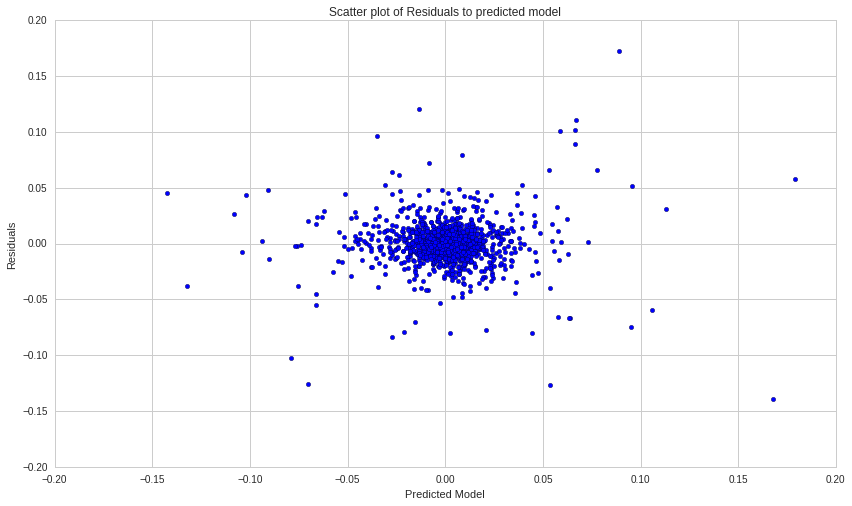

In [12]:
# Predicted values of asset1
y = results.params[0] + results.params[1]*returns1.values

plt.scatter(y, results.resid)
plt.title('Scatter plot of Residuals to predicted model')
plt.xlabel('Predicted Model')
plt.ylabel('Residuals');

Here we can clearly see the plot of the residuals obeys a random pattern, which would indicate that the choice of model was good. This is further accentuated by the near 0 value of the sum of residuals. 

## b. Residual Analysis II
- Run the linear regression function for x and y
- Find and plot the residual of the two data points. 
- Discuss the choice in model. 

In [13]:
p1 = get_pricing('SPY', start_date = '2005-01-01', 
                 end_date = '2010-01-01', 
                 fields = 'price').pct_change()[1:]
p2 = get_pricing('XLF', start_date = '2005-01-01', 
                 end_date = '2010-01-01', 
                 fields = 'price').pct_change()[1:]

## Your code goes here
results2 = smr.linear_model.OLS(p2, sm.add_constant(p1)).fit()

y = results2.params[0] + results2.params[1]*p1

p-value for f-statistic of the breush-pagan test: 1.81776511091e-12
====
Since the p-value obtained is less than alpha (0.05), we reject the null hypothesis of the breush-pagan test, and state that there is presence of heteroskedasticity


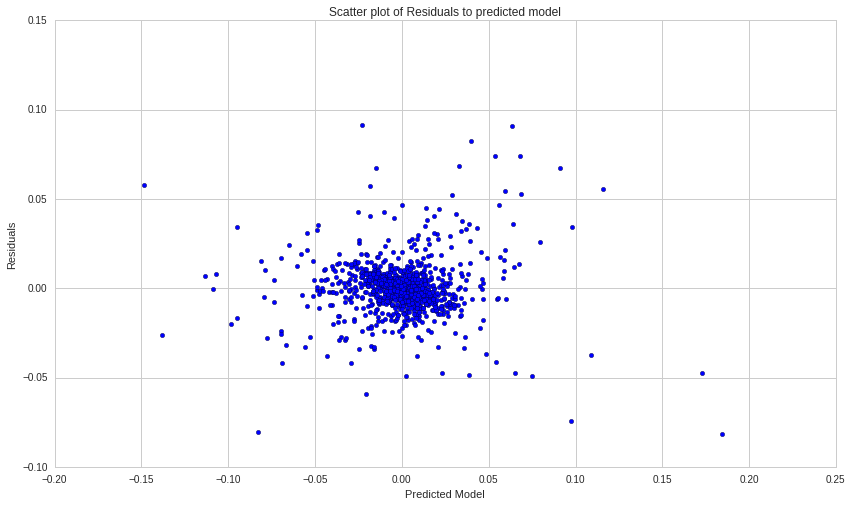

In [14]:
res = results2.resid

plt.scatter(y, res)
plt.title('Scatter plot of Residuals to predicted model')
plt.xlabel('Predicted Model')
plt.ylabel('Residuals')

lm, p_lm, fv, p_fv = het_breushpagan(results2.resid, results2.model.exog)
print 'p-value for f-statistic of the breush-pagan test:', p_fv
print '===='  
print "Since the p-value obtained is less than alpha (0.05), \
we reject the null hypothesis of the breush-pagan test, and state that there is \
presence of heteroskedasticity"

Here, we can clearly see that the choice of model was not adapt for our data as the plot of the residuals gives us an exponential looking function (not random) and the sum of the residuals is much greater than 0. 

While checking for residual is a good way of checking the accuracy of our model choice, we must also check fot heteroscedasticity (checking if there are sub-populations that have different variabilities from others).  
An assumption of the linear regression model is that there is no heteroscedasticity, OLS estimators are no longer the Best Linear Unbiased Estimators if this assumption is broken.  
Read more about heteroscedasticity here https://en.wikipedia.org/wiki/Heteroscedasticity#Consequences

---

Congratulations on completing the Linear Regression exercise!

As you learn more about writing trading algorithms and the Quantopian platform, be sure to check out the [Quantopian Daily Contest](https://www.quantopian.com/contest), in which you can compete for a cash prize every day.

Start by going through the [Writing a Contest Algorithm](https://www.quantopian.com/tutorials/contest) Tutorial.

*This presentation is for informational purposes only and does not constitute an offer to sell, a solicitation to buy, or a recommendation for any security; nor does it constitute an offer to provide investment advisory or other services by Quantopian, Inc. ("Quantopian"). Nothing contained herein constitutes investment advice or offers any opinion with respect to the suitability of any security, and any views expressed herein should not be taken as advice to buy, sell, or hold any security or as an endorsement of any security or company.  In preparing the information contained herein, Quantopian, Inc. has not taken into account the investment needs, objectives, and financial circumstances of any particular investor. Any views expressed and data illustrated herein were prepared based upon information, believed to be reliable, available to Quantopian, Inc. at the time of publication. Quantopian makes no guarantees as to their accuracy or completeness. All information is subject to change and may quickly become unreliable for various reasons, including changes in market conditions or economic circumstances.*